In [65]:
import random
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Dense, Dropout, Input, Lambda
from keras.initializers import RandomNormal
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from sklearn.metrics import classification_report
from itertools import product
from sklearn.metrics import accuracy_score as accuracy
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
import itertools

np.random.seed(1337)  # for reproducibility
input_dim = 784
num_classses = 10
IMG_ROWS, IMG_COLS = 28, 28
num_classes = 10

classes = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

np.set_printoptions(precision=2)

In [2]:
class DataHandler():
    
    def __is_channel_first(self):
        return K.image_data_format() == 'channels_first'
    
    def __preprocess_data(self, X, y):
        '''Preprocess data such that it convert 1D X into 3D array (h, w, c) and normalized the data.'''
    
        if self.__is_channel_first():
            X = X.reshape(X.shape[0], 1, self.img_rows, self.img_cols)
        else:
            X = X.reshape(X.shape[0], self.img_rows,self. img_cols, 1)

        X = X.astype('float32') / 255
        # convert class vectors to binary class matrices
        #y = keras.utils.to_categorical(y, num_classes)
        return X, y
    
    def load_data(self, path = None):
        if path is None:
            self.__load_fashion_data()
    
    def __load_fashion_data(self, path = "FashionData/FashionPDEngDM.npz"):
        '''Load Fashion MNIST data set.'''

        self.img_rows, self.img_cols = 28, 28
        self.ind_04567 = [0, 4, 5 ,6, 7]
        self.ind_12389 = [1, 2, 3 ,8, 9]
        data = np.load(path) # load data
        
        # Extracting data
        # - Classes 04567 have one data observation per class. 
        # - Classes 12389 have 6000 observation for class.
        
        x_train_12389, y_train_12389 = data["x_train_12389_labeled"], data["y_train_12389_labeled"]
        x_test_12389, y_test_12389 = data["x_test_12389"], data["y_test_12389"]
        
        x_train_04567, y_train_04567 = data["x_train_04567_labeled"], data["y_train_04567_labeled"]
        x_train_04567_unlabeled = data["x_train_04567_unlabeled"]
        x_test_04567, y_test_04567 = data["x_test_04567"], data["y_test_04567"]
        
        self.input_shape = (1, self.img_rows, self.img_cols) if self.__is_channel_first() else (self.img_rows, self.img_cols, 1)            
        
        # preprocessing & saving data
        self.x_train_12389, self.y_train_12389 = self.__preprocess_data(x_train_12389, y_train_12389)        
        self.x_train_04567, self.y_train_04567 = self.__preprocess_data(x_train_04567, y_train_04567)        
        
        self.x_test_12389, self.y_test_12389 = self.__preprocess_data(x_test_12389, y_test_12389)
        self.x_test_04567, self.y_test_04567 = self.__preprocess_data(x_test_04567, y_test_04567)
        
        # set the origianlly loaded data        
        self.__set_original_data(self.x_train_04567, self.y_train_04567,
                                 self.x_train_12389, self.y_train_12389,
                                 self.x_test_04567, self.y_test_04567,
                                 self.x_test_12389, self.y_test_12389
                                 )
        
    def __visualize_augmented_data(self, x, y, x_batch, y_batch, num_columns = 2):
        '''Visualize a batch of augmented data.'''
        
        f, axarr = plt.subplots(x.shape[0], num_columns, figsize = (5, 5))
        for j in range(len(x_batch)):
            ground_ind = np.where(y == y_batch[j])
            axarr[j, 0].imshow(x[ground_ind].reshape((self.img_rows, self.img_rows)), cmap='gray')   
            axarr[j, 1].imshow(x_batch[j].reshape((self.img_rows, self.img_rows)), cmap='gray')
            axarr[j, 0].axis('off')
            axarr[j, 1].axis('off')
        plt.show()   
    
    def augment_data(self, use_train, c_04567, N, visualize = False, **kwargs):        
        ''' Augment currectly loaded data.
    
        Params: 
        - use_train: BOOL wheather to augment train data
        - class_04567: BOOL wheather to augment 04567 or 12389
        - N: number of images to generates per class
        - visualize: whether to visualize the augmented images
        - **kwaks: parameters to the Keras.ImageGenerator
        
        Return: (x, y) augmneted data
        '''
        
        num_columns = 2 # for priting
        if kwargs is None:
            print("Parameters for the image generator are empty. Running the generator with the defautl params.")
            
        x, y = self.__get_original_data(return_train = use_train, c_04567 = c_04567)        
        
        img_gen = ImageDataGenerator(**kwargs)    
        #print(img_gen)
        img_gen.fit(x)
        
        data_gen = img_gen.flow(x, y, batch_size = x.shape[0]) # we generate as much as the size of the data
        
        x_aug = []
        y_aug = []        
        
        for i, data_batch in enumerate(data_gen):    
            if N <= i: # in every iteration, one instance per class is generated
                break
                
            x_batch, y_batch = data_batch
            x_aug.append(x_batch)
            y_aug.append(y_batch)
            
            if visualize: 
                self.__visualize_augmented_data(x, y, x_batch, y_batch)

        # reshaping such that the array has the shape of (# data, 28, 28, 1)
        x_aug = np.array(x_aug).reshape((-1, self.img_rows, self.img_rows, 1)) 
        
        #reshaping to shape of (# data)
        y_aug = np.array(y_aug).reshape((-1)) 
        
        self.__set_data(x_aug, y_aug, set_train = use_train, c_04567 = c_04567)        
    
    def get_data(self, return_train, c_04567): 
        '''Getter for the loaded data (can be alrady augmented).'''
        
        if return_train and c_04567:
            return self.x_train_04567, self.y_train_04567
        
        if return_train and not c_04567:
            return self.x_train_12389, self.y_train_12389
        
        if not return_train and c_04567:
            return self.x_test_04567, self.y_test_04567
        
        if not return_train and not c_04567:
            return self.x_test_12389, self.y_test_12389        
        
        
    def __set_data(self, x, y, set_train, c_04567):     
        '''Setter for the loaded data.'''
        if set_train and c_04567:
            self.x_train_04567, self.y_train_04567 = x, y
        
        if set_train and not c_04567:
            self.x_train_12389, self.y_train_12389 = x, y
        
        if not set_train and c_04567:
            self.x_test_04567, self.y_test_04567 = x, y
        
        if not set_train and not c_04567:
            self.x_test_12389, self.y_test_12389 = x, y   
            
            
    def __get_original_data(self, return_train, c_04567): 
        '''Getter for the initially loaded data (they are untouched).'''
        
        if return_train and c_04567:
            return self.x_train_04567_orig, self.y_train_04567_orig
        
        if return_train and not c_04567:
            return self.x_train_12389_orig, self.y_train_12389_orig
        
        if not return_train and c_04567:
            return self.x_test_04567_orig, self.y_test_04567_orig
        
        if not return_train and not c_04567:
            return self.x_test_12389_orig, self.y_test_12389_orig 
    
    def __set_original_data(self, x_train_04567, y_train_04567, x_train_12389, y_train_12389, x_test_04567, y_test_04567,
                           x_test_12389, y_test_12389): 
        '''Setter for the initially loaded data (they are untouched) - is called only once.'''
        
        self.x_train_04567_orig, self.y_train_04567_orig = np.copy(x_train_04567), np.copy(y_train_04567)
        self.x_train_12389_orig, self.y_train_12389_orig = np.copy(x_train_12389), np.copy(y_train_12389)
        self.x_test_04567_orig, self.y_test_04567_orig = np.copy(x_test_04567), np.copy(y_test_04567)
        self.x_test_12389_orig, self.y_test_12389_orig = np.copy(x_test_12389), np.copy(y_test_12389)
           
    
    def __get_val_data(self):
        raise(NotImplementedError())
    
    def train_model(self):
        raise(NotImplementedError())
    
    def validate_model(self):
        raise(NotImplementedError())
    
    def test_model(self):
        raise(NotImplementedError())

In [3]:
def step_decay(epoch):
    '''Learning rate step decay following the original paper.'''
    initial_lrate = 0.001
    drop = 0.99
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def contrastive_loss(y, d):
    ''' Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y) * K.square(d) + y * K.square(K.maximum(margin - d, 0)))

def get_abs_diff(vects):
    x, y = vects
    return K.abs(x - y)  

def get_l2_norm(vects):
    x, y = vects
    return K.sqrt(K.mean(K.square(x - y)))

def abs_diff_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1 

In [108]:
import abc

class NNNetwork():
    
    def __init__(self, data_handler):
        self.dh = data_handler
    
    @abc.abstractmethod
    def define_model_structure(self):
        '''Define a model structure and saves it in self.model.'''
        pass
    
    @abc.abstractmethod
    def train_model(self):
        '''Trains the define model'''
        pass
    
    def compute_accuracy(self, y_val_pred_proba, y_true):
        '''Compute verification accuracy of the siamese model on pairs data set.'''
        
        if self.model is None:
            raise ValueError('Self.model is not defined. Run define_model_structure() and train_model() first. ')

        # getting predictions
        y_val_pred_class = y_val_pred_proba > 0.5 
        y_val_pred_class = y_val_pred_class.reshape(-1)
        
        # compute accuracy
        val_accur = np.sum(y_val_pred_class == y_true) / len(y_true)
        
        print('* Accuracy of classifying the val set: {:.2%}'.format(val_accur))
        return val_accur
    
    def plot_confusion_matrix(self, cm, classes_names, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
        ''' Plots the confusion matrix.
        
        @:param cm: confusion matrix computed by sklearn
        @:param classes_names: names of the classes
        @:param normalize: whether to print normlized matrix
        @:param title: title of the confusion matrix
        @:param cmap: colors of the plot
        
        '''
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")       
        else:
            print('Confusion matrix, without normalization')
        
        print(cm)
        
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes_names))
        plt.xticks(tick_marks, classes_names, rotation=45)
        plt.yticks(tick_marks, classes_names)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        

In [109]:
class SiameseNN(NNNetwork):
            
    def create_pairs(self):
        ''' Create positive and negative pairs between training data of 04567. 
        Alternates between positive and negative pairs. 

        Maximally creates (min(class_size) - 1) * num_classes pairs.
        '''
        
        x, y = self.dh.x_train_04567, self.dh.y_train_04567
        
        inds = self.dh.ind_04567
        class_indices = [np.where(y == i)[0] for i in inds]
        num_classes = len(inds)
        
        x_pairs = []
        y_pairs = []    
        min_data_per_class = min([len(class_indices[d]) for d in range(num_classes)])
        for d in range(num_classes):
            for i in range(min_data_per_class - 1):
                z1, z2 = class_indices[d][i], class_indices[d][i+1]
                x_pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes # this guarantees that the same class will not be selected
                z1, z2 = class_indices[d][i], class_indices[dn][i]
                x_pairs += [[x[z1], x[z2]]]
                y_pairs += [1, 0]
        
        x_pairs, y_pairs = np.array(x_pairs), np.array(y_pairs)                       
        self.x_train_pairs, self.x_val_pairs, self.y_train_pairs, self.y_val_pairs = train_test_split(x_pairs,
                                                                                                      y_pairs,
                                                                                                      test_size=0.3,
                                                                                                      random_state=42)
        print("Number of training pairs is %d " % self.x_train_pairs.shape[0])
        print("Number of val pairs is %d " % self.x_val_pairs.shape[0])  
    
    
    def define_model_structure(self):
        '''Define network structure by Koch. 
        10, 10 --> 7,7, --> 4,4 --> 4,4
        
        '''     
        conv_init_w = RandomNormal(mean=0.0, stddev=0.01)
        init_b = RandomNormal(mean=0.5, stddev=0.01)        
        fc_init_w = RandomNormal(mean=0.0, stddev=2 * 0.1)
        
        model = Sequential()
        model.add(Conv2D(64, kernel_size=(7, 7), activation='relu', input_shape=self.dh.input_shape,
                         kernel_initializer = conv_init_w, bias_initializer = init_b))
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
        model.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer = conv_init_w, bias_initializer = init_b))
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
        model.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer = conv_init_w, bias_initializer = init_b))
        model.add(Flatten())
        
        input_a = Input(shape = self.dh.input_shape)
        input_b = Input(shape = self.dh.input_shape)

        # because we re-use the same instance `base_network`,
        # the weights of the network will be shared across the two branches
        
        processed_a = model(input_a)
        processed_b = model(input_b)

        #abs_diff = Lambda(get_l2_norm, output_shape = abs_diff_output_shape)([processed_a, processed_b])
        
        abs_diff = Lambda(get_abs_diff, output_shape = abs_diff_output_shape)([processed_a, processed_b])

        flattened_weighted_distance = Dense(1, 
                                            activation = 'sigmoid',
                                            kernel_initializer = fc_init_w,
                                            bias_initializer = init_b) (abs_diff)

        model = Model(input=[input_a, input_b], output = flattened_weighted_distance)
        return model
    
    def train_model(self, model, nb_epoch = 5, model_name = 'siamese.h5', load_model = False):
        '''Train model.'''
        
        if load_model:            
            self.model = keras.models.load_model(model_name)
        else:            
            if self.x_train_pairs.shape[0] == 0:
                raise InputError('You need to create training data first. Run create_pairs(..) method first.')


            optimizer = Adam()
            model.compile(loss = 'binary_crossentropy', optimizer = optimizer)

            lrate = LearningRateScheduler(step_decay)
            callbacks_list = [lrate]        

            model.fit([self.x_train_pairs[:, 0], self.x_train_pairs[:, 1]], #pairs 
                      self.y_train_pairs, #labels of the pairs
                      callbacks = callbacks_list,
                      batch_size = 128,
                      nb_epoch=nb_epoch)

            model.save(model_name)
            self.model = model
    
    def compute_accuracy(self):
        '''Computes the verification accuracy.'''
        y_val_pred_proba = self.model.predict([self.x_val_pairs[:, 0], self.x_val_pairs[:, 1]])
        NNNetwork.compute_accuracy(self, y_val_pred_proba = y_val_pred_proba, y_true = self.y_val_pairs)
    
    def compute_one_shot_accuracy(self, max_acc_level = 1, k = 1):
        '''Compute test accuracy of classification on test data 04567.
        
        params:
        - k: number of augmented pictures
        - max_acc_level: if max_acc_level = 2, the class will look accuracy at level 1 and 2
        '''
        # generate examples (k per class) that will be couples with test data


        #x_test_04567_aug_generated, y_test_04567_aug_generated = get_augmented_data(generator = x_train_04567_aug, 
        #                                                                                     x = x_train_04567_labeled,
        #                                                                                     y = y_train_04567_labeled,
        #                                                                                     N = k)

        # create pairs
        x_test_pairs = np.array(list(product(self.dh.x_test_04567, self.dh.x_train_04567_orig)))

        # predict the probability of a pair being similar. 
        y_test_pred_prob = self.model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]])

        # reshaping such that each row contains k*number of class probabilities 
        y_test_pred_prob = y_test_pred_prob.reshape(len(self.dh.x_test_04567), len(self.dh.x_train_04567_orig))

        # getting top k prediction for a class
        y_test_pred_class_inds = y_test_pred_prob.argsort(axis = 1)[:, -max_acc_level:]

        # generating class prediction
        #y_test_pred_k = np.array([mode(self.dh.y_train_04567_orig[y_test_pred_class_inds[i]]) 
        #                                for i in range(len(y_test_pred_class_inds))])[:, 0]
        
        y_test_preds = np.array([self.dh.y_train_04567_orig[y_test_pred_class_inds[i]] 
                                    for i in range(len(y_test_pred_class_inds))])
        
        # accur for up to max level
        accs_at_level = []
        for acc_level in range(1, max_acc_level + 1):            
            # y_test_pred_k and dh.y_test_04567 needs to be 2D
            y_test_pred_at_level = y_test_preds[:, -acc_level:]
            test_accur = np.sum(np.any(y_test_pred_at_level == dh.y_test_04567.reshape(-1, 1), axis = 1)) / len(dh.y_test_04567)
            accs_at_level.append({'accuracy' : test_accur, 'y_pred' : y_test_pred_at_level.reshape(-1)})
            print('*Accuracy of classifying the test set at level {}: {:.2%}'.format(acc_level, test_accur))
        
        return accs_at_level, dh.y_test_04567   

In [110]:
image_gen_params = {
'rotation_range' : 30,
'width_shift_range' : 0.3,
'height_shift_range' : 0.3,
'shear_range' : 0.3,
'horizontal_flip' : True,
'vertical_flip' : True,
'fill_mode': 'nearest',
'zoom_range' : 0.2
 }


dh = DataHandler()
dh.load_data()
dh.augment_data(use_train = True, c_04567 = True, N = 1000, visualize = False, **image_gen_params)

In [111]:
sh = SiameseNN(dh)
sh.create_pairs()
siam_model_structure = sh.define_model_structure()
sh.train_model(siam_model_structure, nb_epoch = 10, load_model = True)

Number of training pairs is 6993 
Number of val pairs is 2997 


C:\Users\azika\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [73]:
sh.compute_accuracy()

* Accuracy of classifying the val set: 97.60%


In [75]:
accs_at_level, y_true_04567 = sh.compute_one_shot_accuracy(max_acc_level = 5)

*Accuracy of classifying the test set at level 1: 38.16%
*Accuracy of classifying the test set at level 2: 52.58%
*Accuracy of classifying the test set at level 3: 64.54%
*Accuracy of classifying the test set at level 4: 83.92%
*Accuracy of classifying the test set at level 5: 100.00%


Normalized confusion matrix
[[ 0.14  0.22  0.03  0.45  0.16]
 [ 0.22  0.24  0.07  0.25  0.22]
 [ 0.04  0.03  0.61  0.11  0.21]
 [ 0.15  0.18  0.04  0.54  0.09]
 [ 0.09  0.14  0.24  0.16  0.37]]


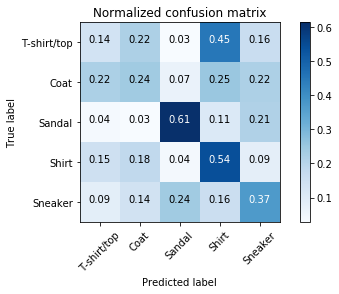

In [112]:
cm = confusion_matrix(y_true_04567, accs_at_level[0]['y_pred'])
class_names_04567 = classes[np.unique(y_true_04567)]
sh.plot_confusion_matrix(cm, classes_names=class_names_04567, normalize=True,
                      title='Normalized confusion matrix')

In [103]:
class_names_04567

array(['T-shirt/top', 'Coat', 'Sandal', 'Shirt', 'Sneaker'], 
      dtype='<U11')

In [102]:
cm

array([[136, 219,  29, 453, 163],
       [221, 242,  66, 253, 218],
       [ 35,  28, 613, 109, 215],
       [149, 183,  39, 544,  85],
       [ 87, 140, 242, 158, 373]])